In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concurrent.futures as fut
from dotenv import load_dotenv  # hack for vs code jupyter extension
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Data.db_connection import get_connection, get_team_roster_df
from prediction.utils import get_season_id

_ = load_dotenv("/mnt/HDD/Ivan/projects/FantasyPrediction/.envrc", override=True)

In [3]:
conn = get_connection()

## Raw data gathering
player_data_sql = """
select 
	bs.*,
	tgl."PLUS_MINUS" as "team_plus_minus", 
	tgl."PLUS_MINUS_RANK"  as team_plus_minus_rank,
	tgl."W_PCT_RANK" as team_w_pct_rank,
	tgl."PTS" as team_points
from (select 
	"PLAYER_NAME", "TEAM_ID", "GAME_ID", "GAME_DATE", "MIN", "FGM", "FG_PCT", "FG3M", "FTM", "FT_PCT", "PTS", "AST" , "STL" , "DREB", "OREB", "BLK", "PLUS_MINUS", "NBA_FANTASY_PTS" 
	from nba.box_score) as bs
inner join nba.team_game_logs tgl on bs."GAME_ID" = tgl."GAME_ID" and bs."TEAM_ID" = tgl."TEAM_ID" ;
"""
player_data_df_raw = pd.read_sql(player_data_sql, con=conn)
display(player_data_df_raw.head())

team_data_sql = """
select * from nba.team_game_logs
"""
team_data_df_raw = pd.read_sql(team_data_sql, con=conn).sort_values('GAME_DATE')
team_data_df_raw = team_data_df_raw.loc[:, [col for col in  team_data_df_raw.columns if '_RANK' not in col]]
display(team_data_df_raw.head())

player_info_df_raw = get_team_roster_df().rename(dict(
	PLAYER="PLAYER_NAME",
	TeamID="TEAM_ID"
), axis=1)
player_info_df_raw.head()

,PLAYER_NAME,TEAM_ID,GAME_ID,GAME_DATE,MIN,FGM,FG_PCT,FG3M,FTM,FT_PCT,...,STL,DREB,OREB,BLK,PLUS_MINUS,NBA_FANTASY_PTS,team_plus_minus,team_plus_minus_rank,team_w_pct_rank,team_points
0,Rasheed Wallace,1610612738,20900001,2009-10-27T00:00:00,23.840000,4,0.444,3,1,0.50,...,0,3,0,2,10,21.6,6.0,35,1,95
1,Kevin Garnett,1610612738,20900001,2009-10-27T00:00:00,33.083333,5,0.500,0,3,0.75,...,1,7,3,3,-4,37.5,6.0,35,1,95
2,Paul Pierce,1610612738,20900001,2009-10-27T00:00:00,37.990000,6,0.462,2,9,0.90,...,1,10,1,1,1,41.7,6.0,35,1,95
3,Marquis Daniels,1610612738,20900001,2009-10-27T00:00:00,17.555000,3,0.600,1,0,0.00,...,1,1,0,0,11,13.2,6.0,35,1,95
4,Eddie House,1610612738,20900001,2009-10-27T00:00:00,12.496667,1,0.333,1,0,0.00,...,0,1,0,1,6,9.2,6.0,35,1,95


,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
19595,2009-10,1610612738,BOS,Boston Celtics,20900001,2009-10-27T00:00:00,BOS @ CLE,W,48.0,32,...,38,20,16.0,9,8,9,27,22,95,6.0
28637,2009-10,1610612757,POR,Portland Trail Blazers,20900003,2009-10-27T00:00:00,POR vs. HOU,W,48.0,33,...,51,23,26.0,9,12,2,27,26,96,9.0
23402,2009-10,1610612746,LAC,Los Angeles Clippers,20900004,2009-10-27T00:00:00,LAC @ LAL,L,48.0,39,...,51,27,20.0,10,4,4,27,15,92,-7.0
23878,2009-10,1610612747,LAL,Los Angeles Lakers,20900004,2009-10-27T00:00:00,LAL vs. LAC,W,48.0,35,...,47,17,16.0,13,4,4,15,27,99,7.0
31969,2009-10,1610612764,WAS,Washington Wizards,20900002,2009-10-27T00:00:00,WAS @ DAL,W,48.0,39,...,46,19,10.0,6,4,9,29,20,102,11.0


,TEAM_ID,SEASON,LeagueID,PLAYER_NAME,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED
0,1610612737,2008,00,Maurice Evans,Maurice,maurice-evans,1,F-G,6-5,220,"NOV 08, 1978",30.0,5,Texas,2230,None
1,1610612737,2008,00,Joe Johnson,Joe,joe-johnson,2,G,6-7,240,"JUN 29, 1981",28.0,7,Arkansas,2207,None
2,1610612737,2008,00,Thomas Gardner,Thomas,thomas-gardner,3,G,6-5,225,"FEB 08, 1985",24.0,1,Missouri,201242,None
3,1610612737,2008,00,Acie Law,Acie,acie-law,4,G,6-3,202,"JAN 25, 1985",24.0,1,Texas A&M,201151,None
4,1610612737,2008,00,Josh Smith,Josh,josh-smith,5,F,6-9,240,"DEC 05, 1985",23.0,4,Oak Hill Academy (VA),2746,None


In [4]:
display(player_data_df_raw.info())
team_data_df_raw.info()
player_info_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349885 entries, 0 to 349884
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PLAYER_NAME           349885 non-null  object 
 1   TEAM_ID               349885 non-null  int64  
 2   GAME_ID               349885 non-null  int64  
 3   GAME_DATE             349885 non-null  object 
 4   MIN                   349885 non-null  float64
 5   FGM                   349885 non-null  int64  
 6   FG_PCT                349885 non-null  float64
 7   FG3M                  349885 non-null  int64  
 8   FTM                   349885 non-null  int64  
 9   FT_PCT                349885 non-null  float64
 10  PTS                   349885 non-null  int64  
 11  AST                   349885 non-null  int64  
 12  STL                   349885 non-null  int64  
 13  DREB                  349885 non-null  int64  
 14  OREB                  349885 non-null  int64  
 15  

None

<class 'pandas.core.frame.DataFrame'>
Index: 33316 entries, 19595 to 16424
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_YEAR        33316 non-null  object 
 1   TEAM_ID            33316 non-null  int64  
 2   TEAM_ABBREVIATION  33316 non-null  object 
 3   TEAM_NAME          33316 non-null  object 
 4   GAME_ID            33316 non-null  int64  
 5   GAME_DATE          33316 non-null  object 
 6   MATCHUP            33316 non-null  object 
 7   WL                 33316 non-null  object 
 8   MIN                33316 non-null  float64
 9   FGM                33316 non-null  int64  
 10  FGA                33316 non-null  int64  
 11  FG_PCT             33316 non-null  float64
 12  FG3M               33316 non-null  int64  
 13  FG3A               33316 non-null  int64  
 14  FG3_PCT            33316 non-null  float64
 15  FTM                33316 non-null  int64  
 16  FTA                3331

## Feature Engineering

#### Features to implement
- add player season statistics 
- team record against other team during season or last n meetings
- teammate fantasy points - think of some kind of formula. Maybe top 2?
- ~~add some categorical variables like the position (G/F/C)~~
- ~~lag the log values of predictors~~
- ~~predict next season based on data from past 2 seasons. Dynamics on how past games might affect next ones can change over time~~
- ~~averages over past n games~~
- ~~current last 10 W/L%~~
- ~~opponent last 10 W/L%~~
- ~~opponent current leage standing~~


#### APIs to look at
- PlayerDashboardByOpponent
- HustleStatsBoxScore
- LeaguePlayerOnDetails
- LeagueStandings

In [5]:
from DataSci.Data.preprocessing import reduce_mem_usage
from DataSci.Data.features import lag_features, rolling_cols, average_deviation, log_cols

In [6]:
team_data_df_raw['win'] = team_data_df_raw['WL'].map(dict(W=1, L=0))
group_dfs = []
for name, group_df in team_data_df_raw.groupby(['SEASON_YEAR', 'TEAM_ID']):
    df = group_df.copy()
    df['LAST10_MIN_PLUS_MINUS'] = df['PLUS_MINUS'].rolling(10, min_periods=1).min()
    df['LAST10_MAX_PLUS_MINUS'] = df['PLUS_MINUS'].rolling(10, min_periods=1).max()
    df['LAST10_MEDIAN_PLUS_MINUS'] = df['PLUS_MINUS'].rolling(10, min_periods=1).median()
    df['LAST10_WIN_PCT'] = df['win'].rolling(10, min_periods=1).mean()
    df['SZN_PLUS_MINUS'] = df['PLUS_MINUS'].expanding(min_periods=1).sum()
    df['SZN_MEDIAN_PLUS_MINUS'] = df['PLUS_MINUS'].expanding(min_periods=1).median()
    df['SZN_WIN_PCT'] = df['win'].expanding(min_periods=1).mean()
    group_dfs.append(df)
team_data_df = pd.concat(group_dfs)
team_data_df['team_abbreviation_opponent'] = team_data_df['MATCHUP'].str[-3:]

opponent_columns = ['LAST10_MIN_PLUS_MINUS', 'LAST10_MAX_PLUS_MINUS', 'LAST10_MEDIAN_PLUS_MINUS', 'LAST10_WIN_PCT', 'SZN_PLUS_MINUS', 'SZN_MEDIAN_PLUS_MINUS', 'SZN_WIN_PCT']
opponent_data_df = team_data_df.loc[:, ['GAME_ID', 'team_abbreviation_opponent'] + opponent_columns].rename(dict(team_abbreviation_opponent='TEAM_ABBREVIATION'), axis=1)
team_data_df = pd.merge(team_data_df, opponent_data_df, on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=('', '_opponent'))
team_data_df.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,SZN_MEDIAN_PLUS_MINUS,SZN_WIN_PCT,team_abbreviation_opponent,LAST10_MIN_PLUS_MINUS_opponent,LAST10_MAX_PLUS_MINUS_opponent,LAST10_MEDIAN_PLUS_MINUS_opponent,LAST10_WIN_PCT_opponent,SZN_PLUS_MINUS_opponent,SZN_MEDIAN_PLUS_MINUS_opponent,SZN_WIN_PCT_opponent
0,2009-10,1610612737,ATL,Atlanta Hawks,20900005,2009-10-28T00:00:00,ATL vs. IND,W,48.0,46,...,11.0,1.000000,IND,-11.0,-11.0,-11.0,0.000000,-11.0,-11.0,0.000000
1,2009-10,1610612737,ATL,Atlanta Hawks,20900021,2009-10-30T00:00:00,ATL vs. WAS,W,48.0,32,...,11.0,1.000000,WAS,-11.0,11.0,0.0,0.500000,0.0,0.0,0.500000
2,2009-10,1610612737,ATL,Atlanta Hawks,20900045,2009-11-01T00:00:00,ATL @ LAL,L,48.0,40,...,11.0,0.666667,LAL,-14.0,8.0,7.0,0.666667,1.0,7.0,0.666667
3,2009-10,1610612737,ATL,Atlanta Hawks,20900059,2009-11-03T00:00:00,ATL @ POR,W,48.0,37,...,8.5,0.750000,POR,-6.0,9.0,-3.0,0.400000,5.0,-3.0,0.400000
4,2009-10,1610612737,ATL,Atlanta Hawks,20900068,2009-11-04T00:00:00,ATL @ SAC,W,48.0,46,...,8.0,0.800000,SAC,-19.0,11.0,-8.0,0.200000,-34.0,-8.0,0.200000


In [7]:
player_data_df_raw['GAME_DATE'] = pd.to_datetime(player_data_df_raw["GAME_DATE"])
player_data_df_raw = player_data_df_raw.sort_values('GAME_DATE')
player_data_df_raw.head()

,PLAYER_NAME,TEAM_ID,GAME_ID,GAME_DATE,MIN,FGM,FG_PCT,FG3M,FTM,FT_PCT,...,STL,DREB,OREB,BLK,PLUS_MINUS,NBA_FANTASY_PTS,team_plus_minus,team_plus_minus_rank,team_w_pct_rank,team_points
0,Rasheed Wallace,1610612738,20900001,2009-10-27,23.840000,4,0.444,3,1,0.5,...,0,3,0,2,10,21.6,6.0,35,1,95
55,Rudy Fernandez,1610612757,20900003,2009-10-27,25.516667,3,0.600,2,0,0.0,...,1,4,0,1,9,18.8,9.0,25,1,96
54,LaMarcus Aldridge,1610612757,20900003,2009-10-27,24.083333,5,0.500,0,1,1.0,...,0,5,1,1,-7,18.7,9.0,25,1,96
53,Travis Outlaw,1610612757,20900003,2009-10-27,32.950000,9,0.643,3,2,1.0,...,2,4,0,1,15,38.8,9.0,25,1,96
52,Andre Miller,1610612757,20900003,2009-10-27,25.810000,3,0.273,1,2,1.0,...,1,3,1,0,1,25.3,9.0,25,1,96


In [8]:
ignore_cols_to_lag = ['PLAYER_NAME', "TEAM_ID", "GAME_ID", "GAME_DATE"]
average_cols = [col for col in player_data_df_raw.columns if 'rank' not in col and col not in [
     'PLAYER_NAME', 'TEAM_ID', 'GAME_ID', 'GAME_DATE']]
required_group_df_cols = ['GAME_ID', 'TEAM_ID', 'GAME_DATE', 'NBA_FANTASY_PTS']
print(average_cols)

def _assign_col_from_group_df(deviation_df, group_df):
    deviation_df['GAME_ID'] = group_df['GAME_ID']
    deviation_df['TEAM_ID'] = group_df['TEAM_ID']
    deviation_df['GAME_DATE'] = group_df['GAME_DATE']
    deviation_df['NBA_FANTASY_PTS'] = group_df['NBA_FANTASY_PTS']
    return deviation_df

def _can_log_col(col):
    return ('deviation' not in col) and ('FANTASY_PTS' not in col)

def get_lagged_features(name, group_df):
        lagged_df = _assign_col_from_group_df(lag_features(group_df, [1,2], average_cols), group_df).dropna()
        lagged_cols = [col for col in lagged_df.columns if 'lag' in col]
        deviation_df1 = average_deviation(lagged_df, 5, subset=lagged_cols)
        deviation_df2 = average_deviation(lagged_df, 15, subset=lagged_cols)
        # log_deviation_df1 = log_cols(deviation_df1 + 1, subset=[col for col in deviation_df1 if _can_log_col(col)])
        # log_deviation_df2 = log_cols(deviation_df2 + 1, subset=[col for col in deviation_df2 if _can_log_col(col)])
        # lagged_df
        df = pd.concat([
              lagged_df.loc[:, required_group_df_cols], deviation_df1, deviation_df2], axis=1)
        df['PLAYER_NAME'] = name[0]
        return df

['MIN', 'FGM', 'FG_PCT', 'FG3M', 'FTM', 'FT_PCT', 'PTS', 'AST', 'STL', 'DREB', 'OREB', 'BLK', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'team_plus_minus', 'team_points']


In [9]:
with fut.ProcessPoolExecutor(8) as exec:
        L = [exec.submit(get_lagged_features, name, group_df) for name, group_df in player_data_df_raw.groupby(['PLAYER_NAME'])]
        L = [task.result() for task in L]

player_data_df = reduce_mem_usage(pd.merge(
        pd.concat(L).sort_values('GAME_DATE'), 
        player_info_df_raw[["TEAM_ID", "PLAYER_NAME", "POSITION"]].drop_duplicates())
)
player_data_df.head()

Memory usage of dataframe is 430.90 MB
Memory usage after optimization is: 111.39 MB
Decreased by 74.2%


,GAME_ID,TEAM_ID,GAME_DATE,NBA_FANTASY_PTS,rolling_average5_MIN_lag_1,rolling_average5_FGM_lag_1,rolling_average5_FG_PCT_lag_1,rolling_average5_FG3M_lag_1,rolling_average5_FTM_lag_1,rolling_average5_FT_PCT_lag_1,...,deviation_15_rolling_average15_STL_lag_2,deviation_15_rolling_average15_DREB_lag_2,deviation_15_rolling_average15_OREB_lag_2,deviation_15_rolling_average15_BLK_lag_2,deviation_15_rolling_average15_PLUS_MINUS_lag_2,deviation_15_rolling_average15_NBA_FANTASY_PTS_lag_2,deviation_15_rolling_average15_team_plus_minus_lag_2,deviation_15_rolling_average15_team_points_lag_2,PLAYER_NAME,POSITION
0,20900029,1610612746,2009-10-30,18.093750,24.875000,4.000000,0.570801,0.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Al Thornton,F
1,20900038,1610612746,2009-10-31,19.703125,30.781250,3.000000,0.385498,0.0,4.500000,0.863281,...,-0.500000,-0.500000,-2.000000,0.000000,-1.000000,-5.000000,2.500000,7.500000,Al Thornton,F
2,20900050,1610612746,2009-11-02,12.398438,28.750000,2.666016,0.340332,0.0,3.666016,0.909180,...,0.333252,0.333252,-2.666016,0.000000,-5.332031,-1.466797,-5.667969,-1.000000,Al Thornton,F
3,20900082,1610612746,2009-11-06,6.898438,26.921875,2.500000,0.338379,0.0,3.250000,0.848633,...,-0.500000,0.250000,0.250000,1.500000,0.500000,0.099976,-1.250000,-11.250000,Al Thornton,F
4,20900091,1610612746,2009-11-07,10.500000,25.156250,2.400391,0.350830,0.0,2.599609,0.678711,...,0.399902,-2.199219,-0.600098,-0.399902,2.800781,-5.761719,8.601562,-1.799805,Al Thornton,F


In [14]:
team_data_cols = ['GAME_ID', 'TEAM_ID', 'SEASON_YEAR'] + opponent_columns + [col + '_opponent' for col in opponent_columns]
team_data_df = team_data_df.loc[:, team_data_cols]
display(team_data_df.head())
df = pd.merge(player_data_df, team_data_df)
df = pd.concat([df, pd.get_dummies(df['POSITION'], drop_first=True)], axis=1)
df.drop("POSITION", axis=1, inplace=True)
display(df.head(8))
df.info()

,GAME_ID,TEAM_ID,SEASON_YEAR,LAST10_MIN_PLUS_MINUS,LAST10_MAX_PLUS_MINUS,LAST10_MEDIAN_PLUS_MINUS,LAST10_WIN_PCT,SZN_PLUS_MINUS,SZN_MEDIAN_PLUS_MINUS,SZN_WIN_PCT,LAST10_MIN_PLUS_MINUS_opponent,LAST10_MAX_PLUS_MINUS_opponent,LAST10_MEDIAN_PLUS_MINUS_opponent,LAST10_WIN_PCT_opponent,SZN_PLUS_MINUS_opponent,SZN_MEDIAN_PLUS_MINUS_opponent,SZN_WIN_PCT_opponent
0,20900005,1610612737,2009-10,11.0,11.0,11.0,1.000000,11.0,11.0,1.000000,-11.0,-11.0,-11.0,0.000000,-11.0,-11.0,0.000000
1,20900021,1610612737,2009-10,11.0,11.0,11.0,1.000000,22.0,11.0,1.000000,-11.0,11.0,0.0,0.500000,0.0,0.0,0.500000
2,20900045,1610612737,2009-10,-8.0,11.0,11.0,0.666667,14.0,11.0,0.666667,-14.0,8.0,7.0,0.666667,1.0,7.0,0.666667
3,20900059,1610612737,2009-10,-8.0,11.0,8.5,0.750000,20.0,8.5,0.750000,-6.0,9.0,-3.0,0.400000,5.0,-3.0,0.400000
4,20900068,1610612737,2009-10,-8.0,11.0,8.0,0.800000,28.0,8.0,0.800000,-19.0,11.0,-8.0,0.200000,-34.0,-8.0,0.200000


,GAME_ID,TEAM_ID,GAME_DATE,NBA_FANTASY_PTS,rolling_average5_MIN_lag_1,rolling_average5_FGM_lag_1,rolling_average5_FG_PCT_lag_1,rolling_average5_FG3M_lag_1,rolling_average5_FTM_lag_1,rolling_average5_FT_PCT_lag_1,...,LAST10_WIN_PCT_opponent,SZN_PLUS_MINUS_opponent,SZN_MEDIAN_PLUS_MINUS_opponent,SZN_WIN_PCT_opponent,C-F,F,F-C,F-G,G,G-F
0,20900029,1610612746,2009-10-30,18.093750,24.87500,4.0,0.570801,0.0,1.0,1.000000,...,0.500000,4.0,2.0,0.500000,False,True,False,False,False,False
1,20900029,1610612746,2009-10-30,36.312500,40.90625,6.0,0.461914,1.0,3.0,0.428955,...,0.500000,4.0,2.0,0.500000,False,False,False,False,True,False
2,20900029,1610612746,2009-10-30,37.812500,37.31250,4.0,0.364014,2.0,2.0,0.500000,...,0.500000,4.0,2.0,0.500000,False,False,False,False,True,False
3,20900029,1610612746,2009-10-30,38.812500,41.78125,10.0,0.587891,0.0,2.0,1.000000,...,0.500000,4.0,2.0,0.500000,False,False,False,False,False,False
4,20900029,1610612746,2009-10-30,21.796875,9.21875,0.0,0.000000,0.0,1.0,0.500000,...,0.500000,4.0,2.0,0.500000,False,True,False,False,False,False
5,20900029,1610612746,2009-10-30,11.500000,32.34375,7.0,0.700195,3.0,2.0,0.666992,...,0.500000,4.0,2.0,0.500000,False,False,False,True,False,False
6,20900029,1610612746,2009-10-30,35.093750,39.43750,10.0,0.666992,0.0,3.0,0.500000,...,0.500000,4.0,2.0,0.500000,True,False,False,False,False,False
7,20900038,1610612746,2009-10-31,19.703125,30.78125,3.0,0.385498,0.0,4.5,0.863281,...,0.666667,12.0,9.0,0.666667,False,True,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421485 entries, 0 to 421484
Columns: 154 entries, GAME_ID to G-F
dtypes: bool(6), category(1), datetime64[ns](1), float16(129), float64(14), int32(2), object(1)
memory usage: 161.6+ MB


In [16]:
player_name = "James Wiseman"
szn_year = get_season_id(2022)
df.query("PLAYER_NAME == @player_name and SEASON_YEAR == @szn_year").head(8)

,GAME_ID,TEAM_ID,GAME_DATE,NBA_FANTASY_PTS,rolling_average5_MIN_lag_1,rolling_average5_FGM_lag_1,rolling_average5_FG_PCT_lag_1,rolling_average5_FG3M_lag_1,rolling_average5_FTM_lag_1,rolling_average5_FT_PCT_lag_1,...,LAST10_WIN_PCT_opponent,SZN_PLUS_MINUS_opponent,SZN_MEDIAN_PLUS_MINUS_opponent,SZN_WIN_PCT_opponent,C-F,F,F-C,F-G,G,G-F
209059,22200002,1610612744,2022-10-18,19.406250,20.593750,5.199219,0.537598,0.199951,0.199951,0.199951,...,0.000000,-14.0,-14.0,0.000000,False,False,False,False,False,False
209071,22200026,1610612744,2022-10-21,17.500000,17.781250,5.199219,0.598145,0.000000,0.199951,0.199951,...,0.500000,-16.0,-8.0,0.500000,False,False,False,False,False,False
209083,22200042,1610612744,2022-10-23,23.703125,17.484375,5.199219,0.669434,0.000000,0.799805,0.399902,...,0.000000,-14.0,-5.0,0.000000,False,False,False,False,False,False
209095,22200055,1610612744,2022-10-25,21.593750,16.390625,5.000000,0.719727,0.000000,1.400391,0.333496,...,0.750000,46.0,9.5,0.750000,False,False,False,False,False,False
209107,22200068,1610612744,2022-10-27,15.203125,15.335938,4.199219,0.681152,0.000000,1.799805,0.533203,...,0.333333,-12.0,-7.5,0.333333,False,False,False,False,False,False
209118,22200082,1610612744,2022-10-29,1.500000,16.890625,4.601562,0.686035,0.000000,1.799805,0.533203,...,0.500000,16.0,2.0,0.500000,False,False,False,False,False,False
209129,22200091,1610612744,2022-10-30,12.296875,14.523438,3.800781,0.552734,0.000000,1.799805,0.533203,...,0.285714,-65.0,-9.0,0.285714,False,False,False,False,False,False
209143,22200104,1610612744,2022-11-01,7.000000,13.898438,3.400391,0.492920,0.000000,1.599609,0.533203,...,0.375000,-11.0,-6.5,0.375000,False,False,False,False,False,False


## Model

#### Traditional sklearn models
- RFC
- Gradient boosting regressor
- ElasticNet

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def get_regression_metrics(model, X, y) -> dict:
    return dict(
        rmse=np.sqrt(mean_squared_error(y, model.predict(X))),
        r2=r2_score(y, model.predict(X))
        # mape=mean_absolute_percentage_error(y, model.predict(X))
    )

features = [col for col in df.columns if col not in [
    "PLAYER_NAME", "SEASON_YEAR", "GAME_DATE", "TEAM_ID", "GAME_ID", "team_abbreviation_opponent", "NBA_FANTASY_PTS"]]
target = "NBA_FANTASY_PTS"

In [19]:
# most basic, see if the box score and some team stats are predictive of nba fantasy points. No past games etc.
X_train, X_valid, y_train, y_valid = train_test_split(df[features], df[target], test_size=4000, random_state=345, shuffle=True)

In [20]:
def run_dtr(params):
    rfr = DecisionTreeRegressor(**params)
    rfr.fit(X_train, y_train)
    print(rfr.feature_names_in_[rfr.feature_importances_ > 0.1])
    print("RFR: ", get_regression_metrics(rfr, X_valid, y_valid))
    return rfr

run_dtr(dict(max_depth=7, min_samples_leaf=10, min_samples_split=10))
run_dtr(dict(max_depth=10, min_samples_leaf=10, min_samples_split=10))
rfr = run_dtr(dict(max_depth=15, min_samples_leaf=10, min_samples_split=10))

['rolling_average15_NBA_FANTASY_PTS_lag_1']
RFR:  {'rmse': 9.749213219815234, 'r2': 0.5209322843809738}
['rolling_average15_NBA_FANTASY_PTS_lag_1']
RFR:  {'rmse': 9.773427597953695, 'r2': 0.5185495828076327}
['rolling_average15_NBA_FANTASY_PTS_lag_1']
RFR:  {'rmse': 9.900058755867313, 'r2': 0.5059927626624146}


In [21]:
print(export_text(rfr, spacing=4, decimals=5, feature_names=list(rfr.feature_names_in_), show_weights=True))

|---- rolling_average15_NBA_FANTASY_PTS_lag_1 <= 23.83594
|    |---- rolling_average15_NBA_FANTASY_PTS_lag_1 <= 14.42578
|    |    |---- rolling_average5_NBA_FANTASY_PTS_lag_1 <= 8.91016
|    |    |    |---- rolling_average15_NBA_FANTASY_PTS_lag_1 <= 7.02539
|    |    |    |    |---- deviation_15_rolling_average15_MIN_lag_1 <= 4.41211
|    |    |    |    |    |---- rolling_average15_NBA_FANTASY_PTS_lag_1 <= 5.31836
|    |    |    |    |    |    |---- rolling_average5_MIN_lag_1 <= 4.81836
|    |    |    |    |    |    |    |---- SZN_PLUS_MINUS <= -198.50000
|    |    |    |    |    |    |    |    |---- rolling_average15_OREB_lag_2 <= 0.81665
|    |    |    |    |    |    |    |    |    |---- rolling_average5_MIN_lag_2 <= 1.67773
|    |    |    |    |    |    |    |    |    |    |---- value: [15.27166]
|    |    |    |    |    |    |    |    |    |---- rolling_average5_MIN_lag_2 >  1.67773
|    |    |    |    |    |    |    |    |    |    |---- deviation_5_rolling_average5_team_plus_minu

In [22]:
"""
#PCA model
scaler = StandardScaler()
pca = PCA(n_components=4)
pca_X_train = pca.fit_transform(scaler.fit_transform(X_train))
"""

lagged_reg = ElasticNet(alpha=0.5, l1_ratio=0.25)
lagged_reg.fit(X_train, y_train)
print("elasticnet: ", get_regression_metrics(lagged_reg, X_valid, y_valid))

lagged_rfc = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_leaf=15, n_jobs=8)
lagged_rfc.fit(X_train, y_train)
print("RFC: ", get_regression_metrics(lagged_rfc, X_valid, y_valid))

lagged_gbr = GradientBoostingRegressor(n_estimators=30, min_samples_split=15, min_samples_leaf=15)
lagged_gbr.fit(X_train, y_train)
print("gradient boostingv2: ", get_regression_metrics(lagged_gbr, X_valid, y_valid))

elasticnet:  {'rmse': 9.605721312593175, 'r2': 0.5349306354789876}
RFC:  {'rmse': 8.817552735882792, 'r2': 0.6081192786156673}
gradient boostingv2:  {'rmse': 9.71363965220799, 'r2': 0.5244220132717251}


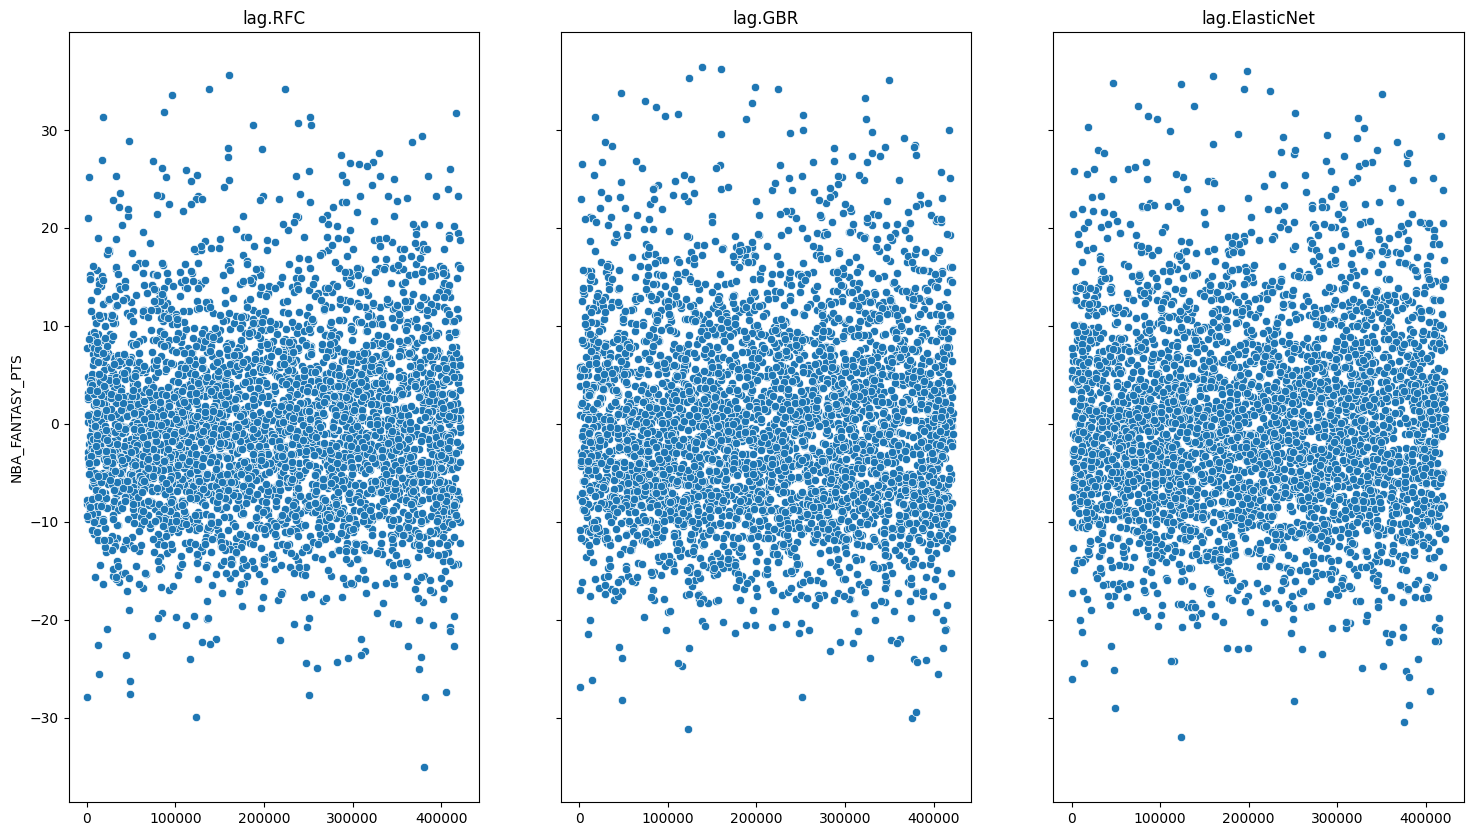

In [23]:
lag_model_mapping = {
    'lag.RFC' : lagged_rfc,
    'lag.GBR' : lagged_gbr, 
    'lag.ElasticNet' : lagged_reg,
}


fig, axs = plt.subplots(1, 3, figsize=(18, 10), sharey=True, sharex=True)
for ax, (title, model) in zip(axs, lag_model_mapping.items()):
    ax.title.set_text(title)
    sns.scatterplot(y_valid - model.predict(X_valid), ax=ax)

#### More complicated RFs
- xgboost

In [25]:
import gc
import xgboost as xgb

In [26]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_valid, label=y_valid)

xgbreg_params = {
    'booster': 'gbtree',
    'max_depth': 20,
    # 'alpha': 0.05, 
    'eta': 0.15, 
    'objective': 'reg:squarederror', 
    'num_parallel_tree': 4,
    'nthread': 4,
    'colsample_bylevel': 0.8,
    'subsample': 0.25,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'sampling_method': 'gradient_based',
    'predictor': 'cpu_predictor',
    'seed': 345,
}

num_rounds = 100  # Number of boosting rounds (trees)
_ = gc.collect()
xgr = xgb.train(xgbreg_params, dtrain, num_rounds)
print("xgboostv2: ", get_regression_metrics(xgr, dtest, y_valid))

xgboostv2:  {'rmse': 7.67585, 'r2': 0.7030312560973133}


In [27]:
_ = gc.collect()
bst = xgb.XGBRegressor(verbosity=0, early_stopping_rounds=30, **xgbreg_params)
bst.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
get_regression_metrics(bst, X_valid, y_valid)

[0]	validation_0-rmse:21.73014
[1]	validation_0-rmse:18.87517
[2]	validation_0-rmse:16.54120
[3]	validation_0-rmse:14.62007
[4]	validation_0-rmse:13.09665
[5]	validation_0-rmse:11.92033
[6]	validation_0-rmse:11.00670
[7]	validation_0-rmse:10.32869
[8]	validation_0-rmse:9.82481
[9]	validation_0-rmse:9.46205
[10]	validation_0-rmse:9.19645
[11]	validation_0-rmse:9.00420
[12]	validation_0-rmse:8.85458
[13]	validation_0-rmse:8.74620
[14]	validation_0-rmse:8.67074
[15]	validation_0-rmse:8.60792
[16]	validation_0-rmse:8.54907
[17]	validation_0-rmse:8.50416
[18]	validation_0-rmse:8.46647
[19]	validation_0-rmse:8.42821
[20]	validation_0-rmse:8.38695
[21]	validation_0-rmse:8.36007
[22]	validation_0-rmse:8.33498
[23]	validation_0-rmse:8.31330
[24]	validation_0-rmse:8.29512
[25]	validation_0-rmse:8.26688
[26]	validation_0-rmse:8.24744
[27]	validation_0-rmse:8.22551
[28]	validation_0-rmse:8.20609
[29]	validation_0-rmse:8.19542
[30]	validation_0-rmse:8.18156
[31]	validation_0-rmse:8.16766
[32]	valid

{'rmse': 7.8162727, 'r2': 0.6920663364277291}

### Looking at predicted values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 155 entries, index to G-F
dtypes: bool(6), category(1), datetime64[ns](1), float16(129), float64(14), int32(2), int64(1), object(1)
memory usage: 68.1+ KB


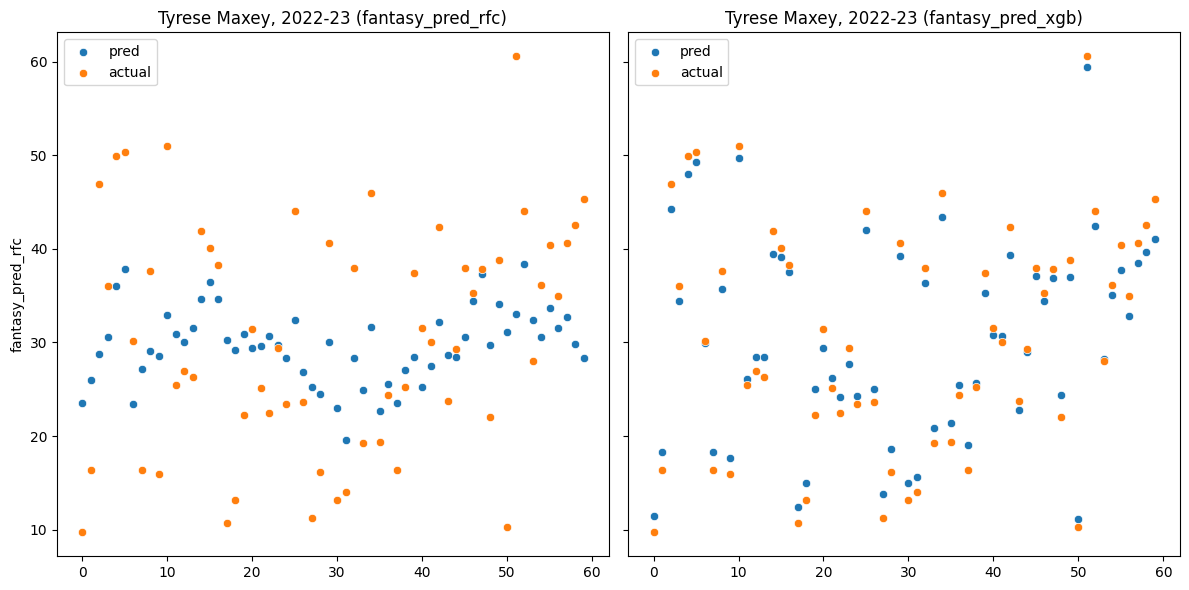

In [31]:
maxey_name = "Tyrese Maxey"
season = "2022-23"
maxey_2022_szn = df.query("PLAYER_NAME == @maxey_name and SEASON_YEAR == @season").reset_index() # .set_index('GAME_DATE')
maxey_2022_szn.info()

X_maxey = maxey_2022_szn[features]
maxey_2022_szn['fantasy_pred_rfc'] = lagged_rfc.predict(X_maxey)
maxey_2022_szn['fantasy_pred_xgb'] = bst.predict(X_maxey)

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)
for pred_col, ax in zip(["fantasy_pred_rfc", "fantasy_pred_xgb"], axs):
    sns.scatterplot(maxey_2022_szn[pred_col], ax=ax, label="pred")
    sns.scatterplot(maxey_2022_szn["NBA_FANTASY_PTS"], ax=ax, label="actual")
    ax.title.set_text(f"Tyrese Maxey, {season} ({pred_col})")
plt.tight_layout()